# 1) Imports

In [365]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import transformers
from scipy.special import softmax
import shap
import torch
%matplotlib inline

# 2) Loading the dataset

In [366]:
# Load dataset
data_source = 'data/realdonaldtrump.csv'
df = pd.read_csv(data_source)
column_names = df.head(0).columns # column names
print(column_names)

Index(['id', 'link', 'content', 'date', 'retweets', 'favorites', 'mentions',
       'hashtags'],
      dtype='object')


In [367]:
# Remove unnecessary columns
df.drop(columns=['link', 'retweets', 'favorites', 'mentions', 'hashtags'], inplace=True)
print(df.head(0).columns)

Index(['id', 'content', 'date'], dtype='object')


In [368]:
print(pd.isnull(df).sum()) # empty cells in each column

id         0
content    0
date       0
dtype: int64


In [369]:
print(df.shape) # number of rows and columns

(43352, 3)


In [370]:
print(df.dtypes) # column types

id          int64
content    object
date       object
dtype: object


In [371]:
print(df.head()) # first 5 rows

           id                                            content  \
0  1698308935  Be sure to tune in and watch Donald Trump on L...   
1  1701461182  Donald Trump will be appearing on The View tom...   
2  1737479987  Donald Trump reads Top Ten Financial Tips on L...   
3  1741160716  New Blog Post: Celebrity Apprentice Finale and...   
4  1773561338  "My persona will never be that of a wallflower...   

                  date  
0  2009-05-04 13:54:25  
1  2009-05-04 20:00:10  
2  2009-05-08 08:38:08  
3  2009-05-08 15:40:15  
4  2009-05-12 09:07:28  


# 2) Visualizing the dataset

In [372]:
plt.rcParams["figure.figsize"] = (12, 12) 

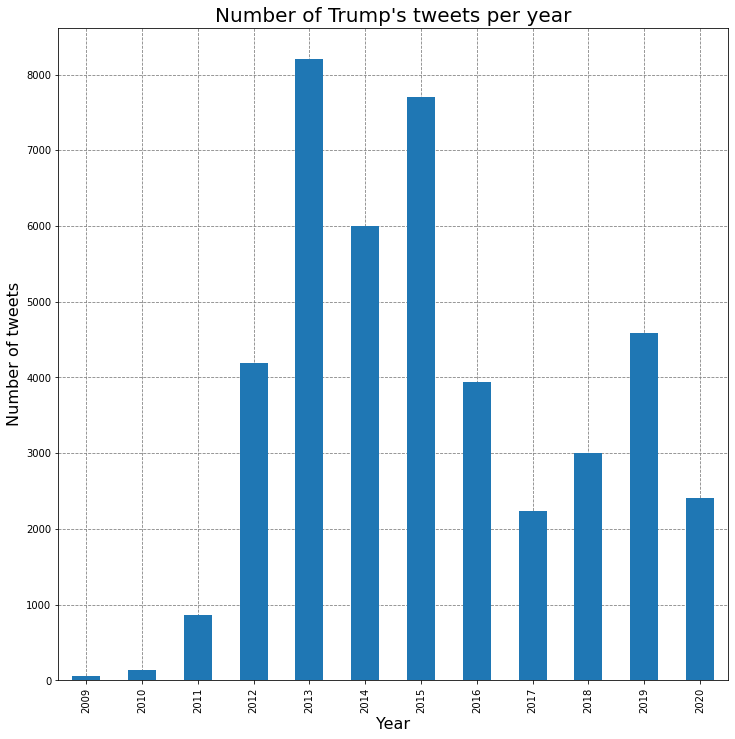

In [373]:
df['date'] = df['date'].astype('datetime64')
ax = df.groupby([df['date'].dt.year])['id'].count().plot(kind='bar')

ax.set_title('Number of Trump\'s tweets per year', fontsize=20)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Number of tweets', fontsize=16)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

# 3) Processing the dataset

In [374]:
df['content'] = df['content'].astype(str)  # getting the context of tweet to analysis
df.head(3)

,id,content,date
0,1698308935,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25
1,1701461182,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08


In [375]:
#Tokenization
reqexp = nltk.tokenize.RegexpTokenizer('\w+')
df['text_token'] = df['content'].str.lower().apply(reqexp.tokenize)

#Remove stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])

#Remove short words
df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

df.head(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\michu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,content,date,text_token,text_string
0,1698308935,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...


(-0.5, 599.5, 399.5, -0.5)

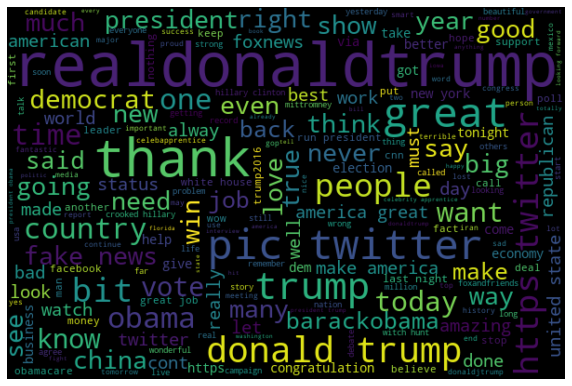

In [376]:
#Word cloud
all_words = ' '.join([word for word in df['text_string']])

wordcloud = WordCloud(width=600, height=400, random_state=2, max_font_size=100)
wordcloud.generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [377]:
df.drop(columns=['id', 'text_token', 'text_string'], inplace=True)

# 4) Prepare the model and predict sentiment

In [378]:
# Swap links and user references in tweets
tweet_list = []
for string in df['content']:
    data = ""
    for word in string.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http'):
            word = 'http'
        data += f'{word} '
    tweet_list.append(data)

In [379]:
# Download the pretrained model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = transformers.AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = transformers.AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

In [380]:
# Encode tweets to tensors
encoded_tweet_list = []
for tweet in tweet_list:
    encoded_tweet_list.append(tokenizer(tweet, return_tensors = 'pt'))

In [381]:
# Predict sentiment

negative, neutral, positive = np.zeros((df.shape[0], 1)), np.zeros((df.shape[0], 1)), np.zeros((df.shape[0], 1))

for i, encoded_tweet in enumerate(encoded_tweet_list):
    output = model(**encoded_tweet)
    score = output[0][0].detach().numpy()
    scores = softmax(score)
    negative[i] = scores[0]
    neutral[i] = scores[1]
    positive[i] = scores[2]

df['Negative'] = negative
df['Neutral'] = neutral
df['Positive'] = positive

In [384]:
#Save results

sentiments = []
for i in range(df.shape[0]):
    negative = df['Negative'][i]
    neutral = df['Neutral'][i]
    positive = df['Positive'][i]

    if negative > neutral and negative > positive:
        if negative > 0.5:
            sentiment = 'Negative'
        else:
            sentiment = 'Slightly negative'
    elif positive > negative and positive > neutral:
        if positive > 0.5:
            sentiment = 'Positive'
        else:
            sentiment = 'Slightly positive'
    else:
        sentiment = 'Neutral'

    sentiments.append(sentiment)

df['Sentiment'] = sentiments
df.to_csv('output/result.csv', index=False)

# 5) Analyzing the results

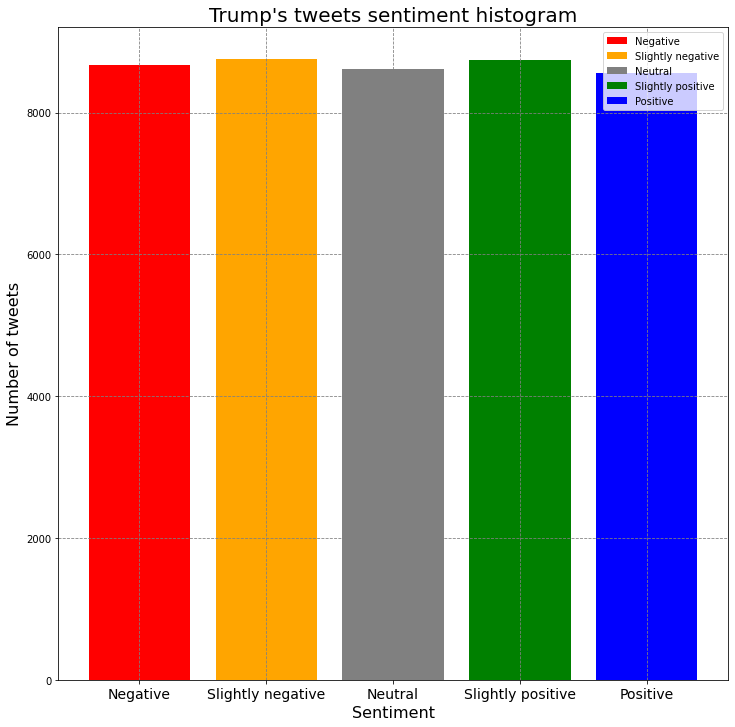

In [385]:
# Histogram of sentiment
df = pd.read_csv('output/result.csv')
df2 = df['Sentiment'].value_counts()

plt.rcParams["figure.figsize"] = (12, 12) 

plt.bar(0, df2['Negative'], color='red', label='Negative')
plt.bar(1, df2['Slightly negative'], color='orange', label='Slightly negative')
plt.bar(2, df2['Neutral'], color='gray', label='Neutral')
plt.bar(3, df2['Slightly positive'], color='green', label='Slightly positive')
plt.bar(4, df2['Positive'], color='blue', label='Positive')


plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('Number of tweets', fontsize=16)
plt.title('Trump\'s tweets sentiment histogram', fontsize=20)

plt.xticks(range(5), ['Negative', 'Slightly negative', 'Neutral', 'Slightly positive', 'Positive'], fontsize=14)
plt.grid(color='gray', linestyle='dashed')
plt.legend()

plt.show()

In [ ]:
# Create pipeline for SHAP analysis
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

labels = ['Negative', 'Neutral', 'Positive']

pipe = transformers.TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

In [386]:
def score_and_visualize(text):
  prediction = pipe([text])
  prediction[0][0]['label'] = 'Negative' 
  prediction[0][1]['label'] = 'Neutral'
  prediction[0][2]['label'] = 'Positive'
  print(prediction[0])

  explainer = shap.Explainer(pipe, output_names=['Negative', 'Neutral', 'Positive'])
  shap_values = explainer([text])

  shap.plots.text(shap_values)

In [387]:
# Results for top 3 positive, negative, neutral and 5 random tweets
sample_tweets = []

# Top 3 positive tweets
df_positive = df[df['Sentiment'] == 'Positive'].sort_values(by='Positive', ascending=False)
top_positive = df_positive[['content', 'Negative', 'Neutral', 'Positive', 'Sentiment']].head(3)

for index, tweet in top_positive.iterrows():
    sample_tweets.append(tweet)

# Top 3 negative tweets
df_negative = df[df['Sentiment'] == 'Negative'].sort_values(by='Negative', ascending=False)
top_negative = df_negative[['content', 'Negative', 'Neutral', 'Positive', 'Sentiment']].head(3)

for index, tweet in top_negative.iterrows():
    sample_tweets.append(tweet)

# Top 3 neutral tweets
df_neutral = df[df['Sentiment'] == 'Neutral'].sort_values(by='Neutral', ascending=False)
top_neutral = df_neutral[['content', 'Negative', 'Neutral', 'Positive', 'Sentiment']].head(3)

for index, tweet in top_neutral.iterrows():
    sample_tweets.append(tweet)

# Random 5 tweets
df_random = df.sample(5)
df_random = df_random[['content', 'Negative', 'Neutral', 'Positive', 'Sentiment']]

for index, tweet in df_random.iterrows():
    sample_tweets.append(tweet)

In [388]:
# Perform shap analysis for each tweet
for tweet in sample_tweets:
    score_and_visualize(tweet['content'])

[{'label': 'Negative', 'score': 0.000846438982989639}, {'label': 'Neutral', 'score': 0.00982886552810669}, {'label': 'Positive', 'score': 0.9893247485160828}]


Partition explainer: 2it [00:40, 40.05s/it]               


[{'label': 'Negative', 'score': 0.0009484881302341819}, {'label': 'Neutral', 'score': 0.011567564681172371}, {'label': 'Positive', 'score': 0.9874839186668396}]


  0%|          | 0/248 [00:00<?, ?it/s]

KeyboardInterrupt: 

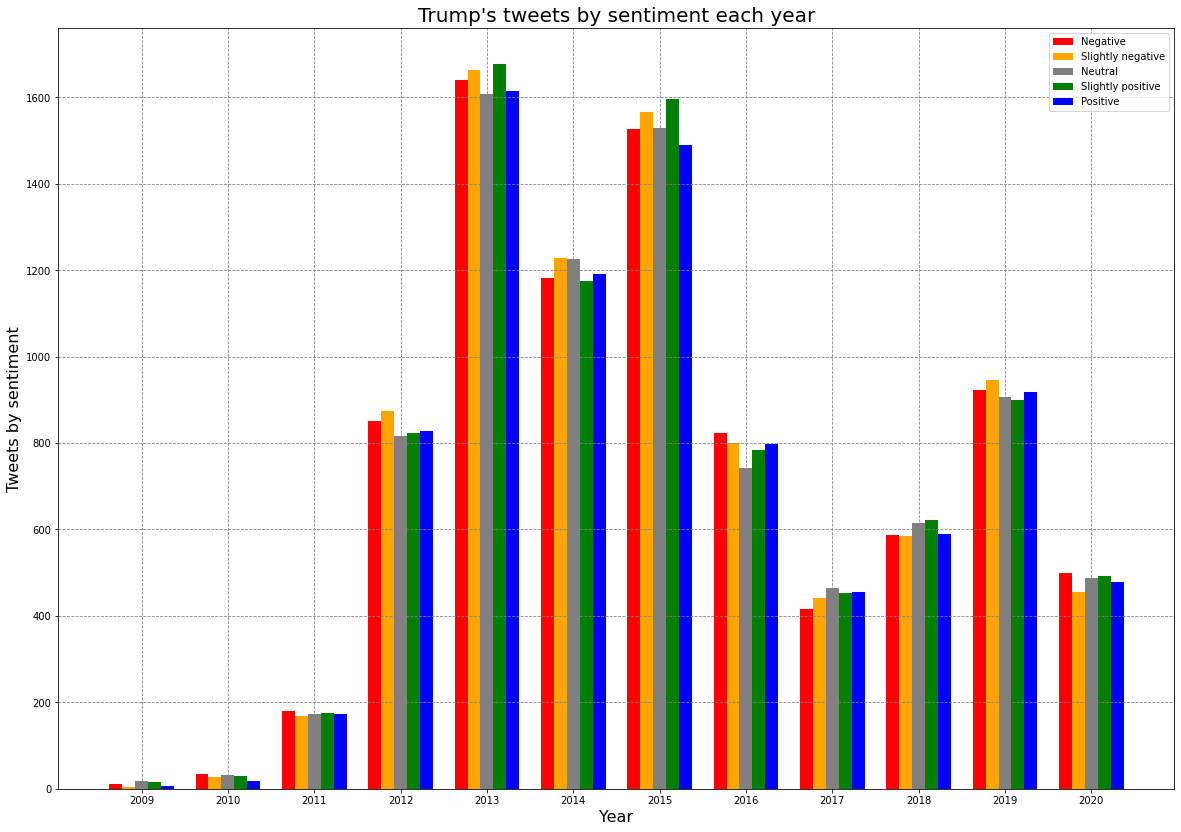

In [389]:
# Plot number of tweets per sentiment for each year
df['year'] = df['date'].apply(lambda x: str(x).split('-')[0])

groups = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

negative_counts = []
slightly_negative_counts = []
neutral_counts = []
slightly_positive_counts = []
positive_counts = []

for group in groups:
    negative = df.query('Sentiment == "Negative" and year == @group').groupby('year').count()['Sentiment']
    slightly_negative = df.query('Sentiment == "Slightly negative" and year == @group').groupby('year').count()['Sentiment']
    neutral = df.query('Sentiment == "Neutral" and year == @group').groupby('year').count()['Sentiment']
    slightly_positive = df.query('Sentiment == "Slightly positive" and year == @group').groupby('year').count()['Sentiment']
    positive = df.query("Sentiment == 'Positive' and year == @group").groupby('year').count()['Sentiment']

    
    if not negative.empty:
        negative_counts.append(negative[group])
    else:
        negative_counts.append(0)

    if not slightly_negative.empty:
        slightly_negative_counts.append(slightly_negative[group])
    else:
        slightly_negative_counts.append(0)

    if not neutral.empty:
        neutral_counts.append(neutral[group])
    else:
        neutral_counts.append(0)

    if not slightly_positive.empty:
        slightly_positive_counts.append(slightly_positive[group])
    else:
        slightly_positive_counts.append(0)

    if not positive.empty:
        positive_counts.append(positive[group])
    else:
        positive_counts.append(0)


plt.rcParams["figure.figsize"] = (20, 14) 

n = 12
x_axis = np.arange(n)
width = 0.15

plt.bar(x_axis-0.3, negative_counts, width, label='Negative', color='red')
plt.bar(x_axis-0.15, slightly_negative_counts, width, label='Slightly negative', color='orange')
plt.bar(x_axis, neutral_counts, width, label='Neutral', color='gray')
plt.bar(x_axis+0.15, slightly_positive_counts, width, label='Slightly positive', color='green')
plt.bar(x_axis+0.3, positive_counts, width, label='Positive', color='blue')

plt.xlabel('Year', fontsize=16)
plt.ylabel('Tweets by sentiment', fontsize=16)
plt.title('Trump\'s tweets by sentiment each year', fontsize=20)

plt.xticks(x_axis, groups)
plt.grid(color='gray', linestyle='dashed')
plt.legend()

plt.show()